<a href="https://colab.research.google.com/github/mrdbourke/zero-to-mastery-ml/blob/master/section-4-unstructured-data-projects/end-to-end-dog-vision-video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multil-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.x and TensorFlow Hub.

## Data

https://www.kaggle.com/c/dog-breed-identification/data 

## Evaluation

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation


In [1]:
# Unzip the uploaded data into Google Drive
#!unzip "drive/My Drive/Dog Vision/dog-breed-identification.zip" -d "drive/My Drive/Dog Vision/"

### Get our workspace ready

* Import TensorFlow 2.x ✅
* Import TensorFlow Hub ✅
* Make sure we're using a GPU ✅

In [2]:
# # Import TensorFlow into Colab
# import tensorflow as tf
# print("TF version:", tf.__version__)

In [3]:
# Run this cell if TensorFlow 2.x isn't the default in Colab
try:
  # %tensorflow_version only exists in Colab
  %tensorflow_version 2.x
except Exception:
  pass

In [4]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub 
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.13.0
TF Hub version: 0.14.0
GPU not available :(


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.

In [5]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [6]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


<Axes: xlabel='breed'>

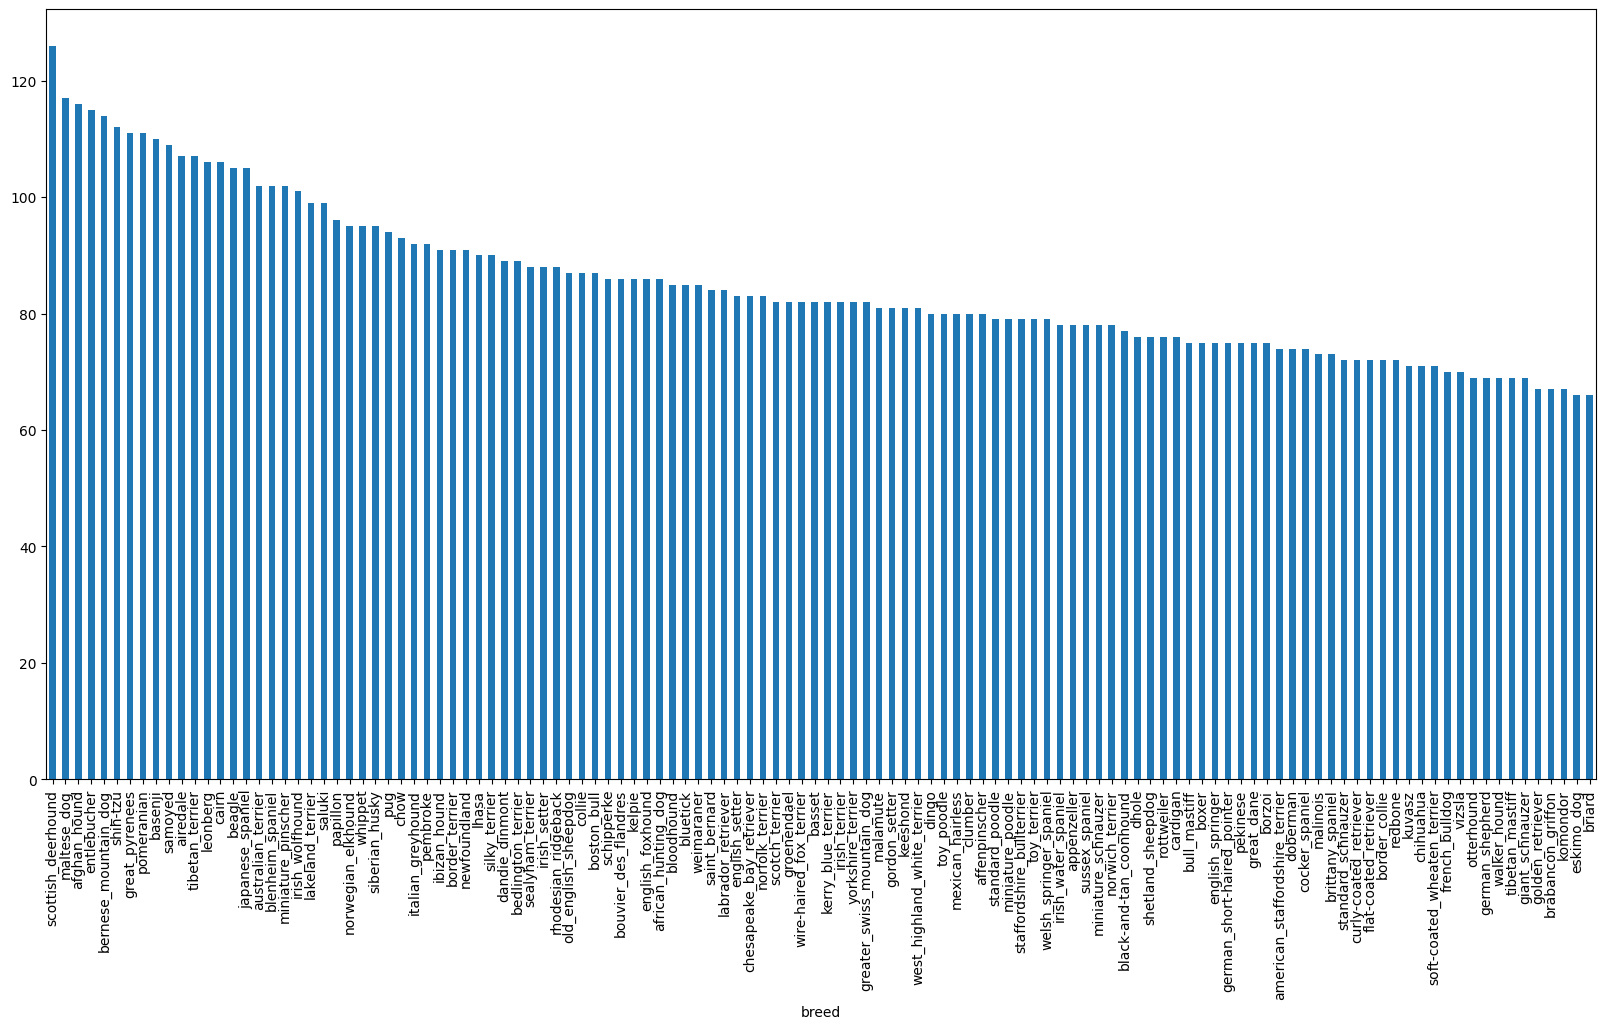

In [7]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [8]:
# What's the median number of images per class?
labels_csv["breed"].value_counts().median()

82.0

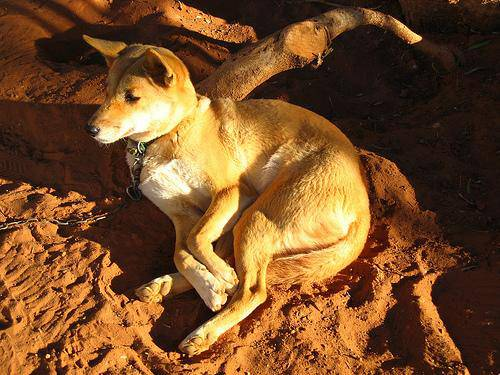

In [9]:
# Let's view an image
from IPython.display import Image
Image("train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels 

Let's get a list of all of our image file pathnames.

In [10]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [11]:
# Create pathnames from image ID's
filenames = ["train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'train/001cdf01b096e06d78e9e5112d419397.jpg',
 'train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'train/002a283a315af96eaea0e28e7163b21b.jpg',
 'train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [12]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("train/")) == len(filenames):
  print("Filenames match actual amount of files - Proceed.")
else:
  print("Filenames do no match actual amount of files, check the target directory.")

Filenames match actual amount of files - Proceed.


In [13]:
# One more check
# Image(filenames[9000])

In [14]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Prepare labels

In [15]:
import numpy as np
labels = labels_csv["breed"].to_numpy() 
# labels = np.array(labels) # does same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [16]:
len(labels)

10222

In [17]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories!")

Number of labels matches number of filenames!


In [18]:
# Find unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [19]:
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [20]:
# Turn single label into array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [21]:
len(labels)

10222

In [22]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [23]:
len(boolean_labels)

10222

In [24]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19], dtype=int64),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [25]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [26]:
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [27]:
filenames[:10]

['train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'train/001cdf01b096e06d78e9e5112d419397.jpg',
 'train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'train/002a283a315af96eaea0e28e7163b21b.jpg',
 'train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'train/0042188c895a2f14ef64a918ed9c7b64.jpg']

### Creating our own validation set
Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [28]:
X = filenames
y = boolean_labels

In [29]:
len(filenames)

10222

Begin with ~1000 images and increase

In [30]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [31]:
# split data
from sklearn.model_selection import train_test_split

# training and validation
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [32]:
# Training data
X_train[:5], y_train[:2]

(['train/00bee065dcec471f26394855c5c2f3de.jpg',
  'train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, Fa

## Preprocessing Images (images into Tensors)

In [33]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [34]:
image.max(), image.min()

(255, 0)

In [35]:
image[:2]

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)

In [36]:
# turn image into tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

In [37]:
# Define image size
IMG_SIZE = 224

# function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

In [38]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the assosciated label,
  processes the image and reutrns a typle of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [39]:
# Demo of the above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117759],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

In [40]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Shuffles if training data - no shuffle if validation
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [41]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [42]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [43]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image 
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [44]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [45]:
# visualize the data
# train_images, train_labels = next(train_data.as_numpy_iterator())
# show_25_images(train_images, train_labels)

In [46]:
# # Now let's visualize our validation set
# val_images, val_labels = next(val_data.as_numpy_iterator())
# show_25_images(val_images, val_labels)

In [47]:
IMG_SIZE

224

In [48]:
# Build model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [49]:
INPUT_SHAPE

[None, 224, 224, 3]

In [50]:
# function to build Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [51]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


In [52]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [53]:
import datetime

# function to build a TensorBoard callback
def create_tensorboard_callback():
  # log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Dog Vision/logs",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [54]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training on subset 

In [55]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [56]:
# Check to make sure we're still running on a GPU
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU not available


In [57]:
# function to train and return trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model

In [58]:
# Fit the model to the data
# model = train_model()

## Making and evaluating predictions using a trained model 

In [59]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [60]:
# Make predictions on validation data
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 12s 1s/step


array([[1.3111447e-03, 3.4293383e-03, 5.7800305e-03, ..., 1.3575627e-02,
        4.7571687e-03, 2.5925257e-03],
       [2.0025300e-02, 3.2810236e-03, 1.7510738e-02, ..., 3.1827237e-03,
        4.6785742e-02, 6.1452161e-03],
       [1.3205523e-03, 1.3937840e-03, 9.7981282e-04, ..., 3.4886959e-03,
        2.4399301e-03, 1.2809392e-03],
       ...,
       [9.9812401e-04, 4.7240400e-04, 1.4774922e-03, ..., 9.6653812e-03,
        2.7240121e-03, 4.4060810e-03],
       [1.4210788e-02, 1.2020558e-03, 3.7100860e-03, ..., 4.1563273e-03,
        6.5280763e-03, 3.2993639e-03],
       [3.1939350e-02, 4.2735384e-05, 2.9021341e-03, ..., 1.7693673e-03,
        1.2782513e-03, 2.6623150e-03]], dtype=float32)

In [61]:
predictions[0]

array([0.00131114, 0.00342934, 0.00578003, 0.00803968, 0.00330656,
       0.00053901, 0.00603479, 0.01628853, 0.00517435, 0.00666693,
       0.00122216, 0.00661222, 0.00716413, 0.00010325, 0.04657114,
       0.0002964 , 0.00778166, 0.01775621, 0.00217644, 0.01439881,
       0.00202082, 0.00171154, 0.00352577, 0.00033325, 0.00620339,
       0.00529225, 0.00963154, 0.02013989, 0.00142596, 0.00142143,
       0.00304493, 0.00146961, 0.00313905, 0.00660336, 0.00288621,
       0.00133327, 0.02724305, 0.00142656, 0.00381555, 0.00261479,
       0.00163145, 0.0483922 , 0.00307635, 0.00213116, 0.00393526,
       0.00444004, 0.01619983, 0.01244424, 0.00359345, 0.00095471,
       0.00033593, 0.00506798, 0.00327663, 0.00080917, 0.00163292,
       0.015899  , 0.00157236, 0.00370514, 0.01740278, 0.00020128,
       0.02222863, 0.00126506, 0.0842143 , 0.01205337, 0.01341841,
       0.00131289, 0.00179688, 0.0004353 , 0.00319757, 0.06015901,
       0.01776536, 0.001382  , 0.02865389, 0.00193136, 0.00738

In [62]:
# First prediction
index = 42
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[0.00194715 0.0051303  0.00301444 0.01459879 0.00661914 0.00209177
 0.00174928 0.02230292 0.00073861 0.00344699 0.00413525 0.07213917
 0.00107623 0.0045948  0.00360874 0.01539424 0.00544681 0.00049058
 0.00148546 0.0071103  0.00096183 0.00083133 0.00127508 0.00733958
 0.00289002 0.0108755  0.00162315 0.00432437 0.01770761 0.01483928
 0.00252043 0.00455401 0.00123264 0.00216595 0.00084342 0.00742861
 0.00162879 0.00127778 0.00175299 0.00936052 0.01753436 0.00090347
 0.00292089 0.01028156 0.00419598 0.00447289 0.00825394 0.00404551
 0.00061224 0.02048939 0.00561925 0.00344463 0.00146362 0.00293428
 0.00999473 0.00553445 0.00148923 0.00365867 0.00529749 0.01608898
 0.00829596 0.00119567 0.0151509  0.00329109 0.00177664 0.05087983
 0.01198299 0.01113983 0.01166966 0.00309749 0.01076292 0.00246825
 0.00592756 0.00215555 0.00676097 0.00192073 0.00169904 0.00897332
 0.00107491 0.09702057 0.00416034 0.0051083  0.0004256  0.00686475
 0.00108815 0.01402238 0.00587017 0.12864366 0.00063721 0.0110

In [63]:
unique_breeds[113]

'walker_hound'

In [64]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'airedale'

In [65]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [66]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and reutrns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [67]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  
  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

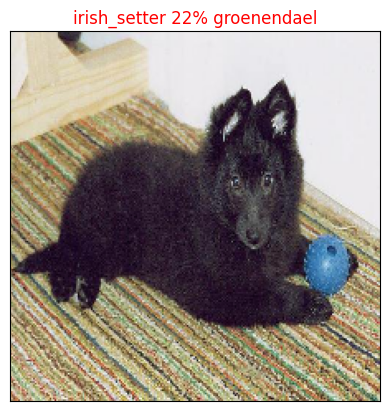

In [68]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

In [69]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

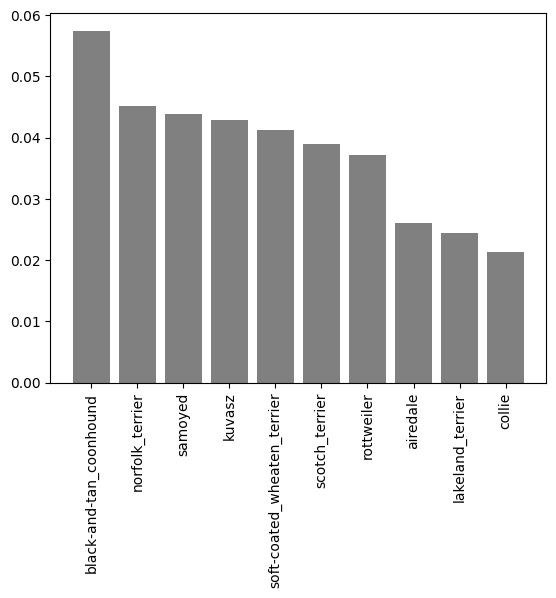

In [70]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

Now we've got some function to help us visualize our predictions and evaluate our modle, let's check out a few.

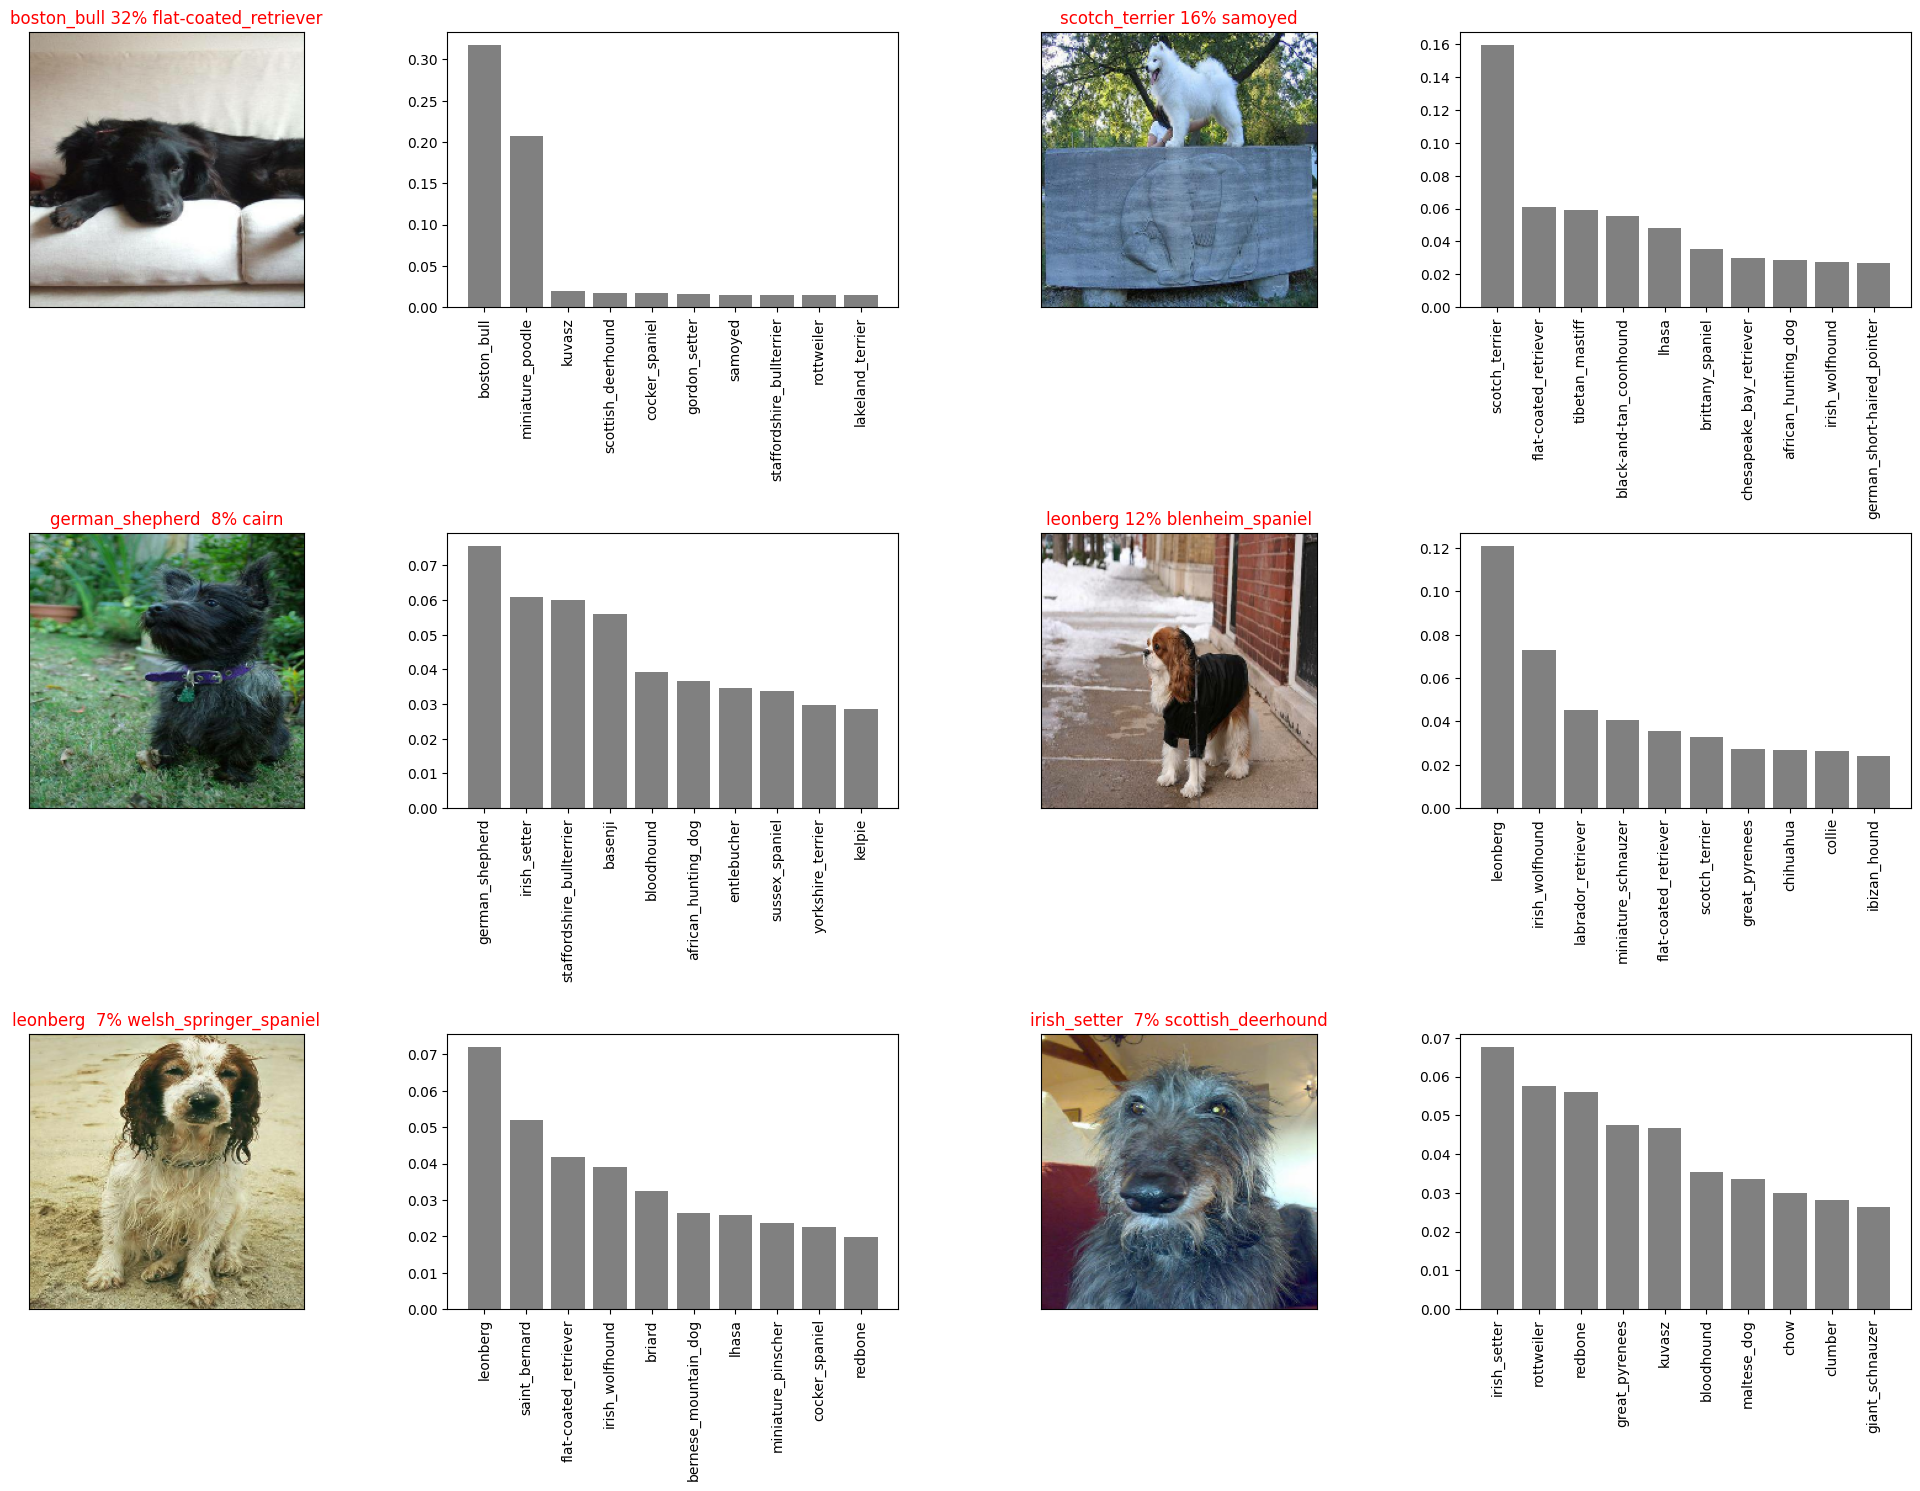

In [71]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

In [72]:
# function to save a model

def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("models", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [73]:
# function to load trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path, 
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [74]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: models\20230908-142553-1000-images-mobilenetv2-Adam.h5...


C:\Users\kevin\PycharmProjects\dog_vision\venv\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'models\\20230908-142553-1000-images-mobilenetv2-Adam.h5'

In [75]:
# Load a trained model
loaded_1000_image_model = load_model('models/20230908-102533-1000-images-mobilenetv2-Adam.h5')

Loading saved model from: models/20230908-102533-1000-images-mobilenetv2-Adam.h5


In [76]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 11s 1s/step - loss: 5.8241 - accuracy: 0.0050


[5.824072360992432, 0.004999999888241291]

In [77]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 11s 1s/step - loss: 5.5082 - accuracy: 0.0350


[5.5082011222839355, 0.03500000014901161]

## Training on the full data

In [78]:
len(X), len(y)

(10222, 10222)

In [79]:
# Create a data batch with the full data set
full_data = create_data_batches(X, y)

Creating training data batches...


In [80]:
full_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [81]:
# Create a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [82]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [85]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=3,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/3
320/320 [==============================] - 621s 2s/step - loss: 0.1503 - accuracy: 0.9648
Epoch 2/3
320/320 [==============================] - 696s 2s/step - loss: 0.1040 - accuracy: 0.9788
Epoch 3/3
320/320 [==============================] - 930s 3s/step - loss: 0.0739 - accuracy: 0.9889


In [86]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: models\20230908-153442-full-image-set-mobilenetv2-Adam.h5...


'models\\20230908-153442-full-image-set-mobilenetv2-Adam.h5'

In [87]:
# Load in the full model
loaded_full_model = load_model('models/20230908-112043-full-image-set-mobilenetv2-Adam.h5')

Loading saved model from: models/20230908-112043-full-image-set-mobilenetv2-Adam.h5


## Make predictions on the test dataset

In [88]:
# Load test image filenames
test_path = "test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['test/000621fb3cbb32d8935728e48679680e.jpg',
 'test/00102ee9d8eb90812350685311fe5890.jpg',
 'test/0012a730dfa437f5f3613fb75efcd4ce.jpg',
 'test/001510bc8570bbeee98c8d80c8a95ec1.jpg',
 'test/001a5f3114548acdefa3d4da05474c2e.jpg',
 'test/00225dcd3e4d2410dd53239f95c0352f.jpg',
 'test/002c2a3117c2193b4d26400ce431eebd.jpg',
 'test/002c58d413a521ae8d1a5daeb35fc803.jpg',
 'test/002f80396f1e3db687c5932d7978b196.jpg',
 'test/0036c6bcec6031be9e62a257b1c3c442.jpg']

In [89]:
len(test_filenames)

10357

In [90]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [91]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [92]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 798s 2s/step


In [93]:
# Save predictions (NumPy array) to csv file (for access later)
np.savetxt("preds_array.csv", test_predictions, delimiter=",")

In [94]:
# Load predictions (NumPy array) from csv file
test_predictions = np.loadtxt("preds_array.csv", delimiter=",")

In [95]:
test_predictions[:10]

array([[5.38199210e-08, 8.00241029e-09, 1.25247354e-10, ...,
        1.56874469e-09, 1.47350818e-07, 2.03828243e-08],
       [7.94846637e-05, 2.14501888e-05, 4.56186353e-06, ...,
        1.15234826e-07, 1.15308376e-05, 1.46022160e-06],
       [3.02693692e-08, 5.18909801e-05, 1.18793969e-05, ...,
        7.91261846e-05, 7.34030664e-07, 1.73887273e-07],
       ...,
       [7.32259025e-07, 6.46656204e-08, 1.76671278e-07, ...,
        3.29319549e-09, 2.54009631e-08, 3.31450480e-07],
       [5.71723291e-09, 2.11699700e-07, 1.32721277e-06, ...,
        8.04844094e-05, 8.28866723e-06, 5.10979739e-08],
       [1.49364075e-06, 5.34450173e-08, 1.15491936e-08, ...,
        1.11583653e-09, 3.02084313e-09, 4.53827352e-06]])

In [96]:
test_predictions.shape

(10357, 120)

In [97]:
# ["id"] + list(unique_breeds)

In [98]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [99]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [100]:
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00102ee9d8eb90812350685311fe5890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0012a730dfa437f5f3613fb75efcd4ce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001510bc8570bbeee98c8d80c8a95ec1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,001a5f3114548acdefa3d4da05474c2e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,5.381992e-08,8.002410e-09,1.252474e-10,1.368469e-09,2.240125e-10,3.278939e-08,1.728606e-10,1.273042e-09,1.423281e-09,...,2.505786e-09,2.558158e-09,9.864403e-10,3.769852e-10,1.840096e-09,3.440068e-09,2.017165e-09,1.568745e-09,1.473508e-07,2.038282e-08
1,00102ee9d8eb90812350685311fe5890,7.948466e-05,2.145019e-05,4.561864e-06,2.254434e-06,2.413445e-04,1.589622e-05,5.208478e-05,6.620804e-05,2.493721e-06,...,8.933339e-06,2.066976e-05,3.955807e-06,2.535714e-05,1.422984e-06,2.585519e-05,7.304389e-04,1.152348e-07,1.153084e-05,1.460222e-06
2,0012a730dfa437f5f3613fb75efcd4ce,3.026937e-08,5.189098e-05,1.187940e-05,1.688443e-07,1.078549e-07,1.271022e-06,1.263548e-07,5.843915e-09,1.178911e-06,...,1.271086e-08,6.375483e-09,8.902256e-06,5.048500e-05,1.421279e-05,3.362126e-06,8.700634e-09,7.912618e-05,7.340307e-07,1.738873e-07
3,001510bc8570bbeee98c8d80c8a95ec1,1.242528e-03,2.729888e-04,5.423809e-06,3.851851e-05,1.111884e-03,1.116119e-04,3.176195e-08,2.385996e-05,7.943871e-06,...,5.296780e-05,9.135920e-08,4.650354e-05,2.904879e-07,1.240106e-05,1.921279e-07,2.824225e-10,5.399514e-03,3.820226e-08,6.796363e-05
4,001a5f3114548acdefa3d4da05474c2e,3.785384e-04,3.762924e-04,3.751688e-07,4.035586e-07,4.648778e-07,3.495239e-08,5.483149e-07,1.006101e-07,1.285333e-06,...,2.155286e-06,3.277923e-08,6.912994e-08,9.431100e-08,2.327955e-07,1.837161e-07,3.339719e-08,6.737272e-07,2.904507e-07,1.258290e-05


In [102]:
# Save our predictions dataframe to CSV for submission to Kaggle
preds_df.to_csv("full_model_predictions_submission_1_mobilenetV2.csv",
                index=False)

## Making predictions on custom images

In [103]:
# Get custom image filepaths
custom_path = "my-dog-photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [104]:
custom_image_paths

['my-dog-photos/dog_01.png',
 'my-dog-photos/dog_02.png',
 'my-dog-photos/dog_03.png',
 'my-dog-photos/dog_04.png',
 'my-dog-photos/dog_05.png',
 'my-dog-photos/dog_06.png']

In [105]:
# Turn custom images into batch datasets 
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [106]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

1/1 [==============================] - 1s 522ms/step


In [107]:
custom_preds.shape

(6, 120)

In [108]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['golden_retriever',
 'golden_retriever',
 'pug',
 'brittany_spaniel',
 'american_staffordshire_terrier',
 'blenheim_spaniel']

In [109]:
# Get custom images (our unbatchify() function won't work since there aren't labels... maybe we could fix this later)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

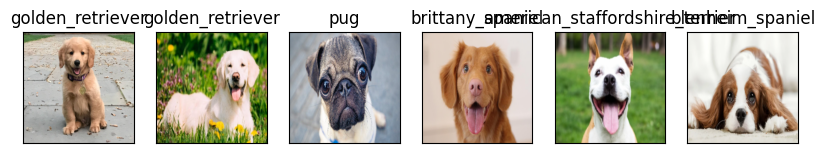

In [110]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, len(custom_images), i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)